In [ ]:
suppressMessages(library(tidyr))
suppressMessages(library(dplyr))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(ggtree))
suppressMessages(library(hash))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(ggalluvial))
suppressMessages(library(grid))
suppressMessages(library(ggrepel))
suppressMessages(library(ggdark))
suppressMessages(library(tidyverse))
suppressMessages(library(ggrastr))
suppressMessages(library(ggpubr))
suppressMessages(library(readxl))
suppressMessages(library(ggsci))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(aplot))
suppressMessages(library(Seurat))
suppressMessages(library(gridExtra))

Figure 2A 

In [80]:
GetGroupCenter <- function(df_umap, group){
  GroupCenter <- df_umap %>% group_by(eval(str2lang(group))) %>% summarise(UMAP_1 = median(UMAP_1),UMAP_2 = median(UMAP_2)) %>% as.data.frame()
  colnames(GroupCenter)[1] <- "GroupCenter"
  return(GroupCenter)
}

UmapPlot <- function(df, cluster, df_center, labelfontsize, axistitlefontsize, pointsize, pointalpha,
                    xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,labelfont,
                    xaxislengthfold,yaxislengthfold){
  p <- ggplot() + 
    geom_point(df, mapping=aes(x = UMAP_1, y = UMAP_2, color = eval(str2lang(cluster))), size = pointsize, 
               alpha = pointalpha) +
    dark_theme_void()+
    scale_x_continuous(limits = c(xmin-2, xmax))+
    scale_y_continuous(limits = c(ymin-2, ymax))+
    theme(axis.text = element_blank())+
    theme(axis.ticks = element_blank())+
    theme(panel.border = element_blank())+
    theme(axis.title = element_blank())+
    scale_color_manual(values=mycolor)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin+abs(xmin)*xaxislengthfold, yend=ymin), 
                 arrow = arrow(length=unit(0.2, "cm")), color="white", linewidth=axislinesize)+
    geom_segment(aes(x=xmin, y=ymin, xend=xmin, yend=ymin+abs(ymin)*yaxislengthfold), 
                 arrow = arrow(length=unit(0.2, "cm")), color="white", linewidth=axislinesize)+
    annotate("text", x = xmin + 1.5, y = ymin - 1, label = "UMAP_1",
             color="white",size = axistitlefontsize, fontface="bold", family = axistitlefont) +
    annotate("text", x = xmin - 1, y = ymin + 1.5, label = "UMAP_2",
             color="white",size = axistitlefontsize, fontface="bold" ,angle=90, family = axistitlefont) +
    geom_text(data = df_center[which(df_center$GroupCenter %in% unique(df[,cluster])),], mapping=aes(x = UMAP_1, y = UMAP_2, label=GroupCenter), 
              fontface="bold",color = "white",size = labelfontsize, family = labelfont)+
    theme(legend.position = "none")
  return(p)
}

MultiUmaplots <- function(df,group){
  umap_groupname_list <- NULL
  for (i in seq_len(nlevels(df[,group]))){
    groupnames <- levels(df[,group])
    df_tmp <- df[which(df[,group] == groupnames[i]),]
    umap_groupname_list[[i]] <-  UmapPlot(df_tmp, umapCluster, ct_center, labelfontsize, axistitlefontsize, pointsize, pointalpha)
  }
  return(umap_groupname_list)
}
date()

[1] "Thu Jan  9 16:32:33 2025"

In [15]:
# umapCluster 
# 
RunUmapPlot <- function(obj,FilterCluster = NULL,umapCluster,ClusterColour = NULL,
                       specificgroup = NULL,umapGroup = NULL,
                       pointsize = 0.1,pointalpha = 0.5,
                       labelfontsize = 5,axistitlefontsize = 5,
                       axistitlefont = "sans",axislinesize = 1,
                       labelfont = "sans",plot_width = 10,plot_height = 8,
                        xaxislengthfold = 1,yaxislengthfold= 1,cellcycle_annotation = NULL,
                        saveannotation = TRUE,Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5
                       ){
    df_umap_ct = obj@reductions$umap@cell.embeddings %>%
      as.data.frame() %>% 
      cbind(Cluster = obj@meta.data$clusters) %>%
      cbind(Group = obj@meta.data$mice) 
    if (is.null(obj@meta.data$tissue2)){
      df_umap_ct$Tissue <- obj@meta.data$tissue
    }else{
      df_umap_ct$Tissue <- obj@meta.data$tissue2
    }
    if (!is.null(obj@meta.data$platform)){
      df_umap_ct$Platform <- obj@meta.data$platform
      df_umap_ct$Platform <- as.factor(df_umap_ct$Platform)
    }

    df_umap_ct$Cluster <- as.factor(df_umap_ct$Cluster)
    df_umap_ct$Cluster <- factor(df_umap_ct$Cluster, levels=sort(as.numeric(levels(df_umap_ct$Cluster))))
    df_umap_ct$Group <- as.factor(df_umap_ct$Group)
    df_umap_ct$Tissue <- as.factor(df_umap_ct$Tissue)

    if (!is.null(FilterCluster)){
      if (filtercluster_var == umapCluster){
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,umapCluster] %in% FilterCluster),]
      }else{
        df_umap_ct <- df_umap_ct[which(!df_umap_ct[,filtercluster_var] %in% FilterCluster),]
      }
    }

    xmin <- min(df_umap_ct$UMAP_1)-2
    xmax <- max(df_umap_ct$UMAP_1)+2
    ymin <- min(df_umap_ct$UMAP_2)-2
    ymax <- max(df_umap_ct$UMAP_2)+2
    
    # lwm 
    print(head(df_umap_ct))

    ct_center <- GetGroupCenter(df_umap_ct, umapCluster)
    

    nCluster = length(unique(df_umap_ct[,umapCluster]))

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- levels(df_umap_ct[,umapCluster])[sort(unique(df_umap_ct[,umapCluster]))]
      }else{
        mycolor <- ClusterColour
      }
    }


    if (is.null(specificgroup)){
      if (is.null(umapGroup)){
        umap_overall <- UmapPlot(df_umap_ct, umapCluster, ct_center, labelfontsize, axistitlefontsize,
                                 pointsize, pointalpha,xmin,xmax,ymin,ymax,mycolor,axistitlefont,axislinesize,
                                 labelfont,xaxislengthfold,yaxislengthfold)
        ggsave(paste0("umap_overall_",umapCluster,".pdf"),umap_overall,device='pdf',width = plot_width, 
               height = plot_height) # ok # 
      }else{
        umap_groupname_list <- MultiUmaplots(df_umap_ct, umapGroup)
        umap_group <- ggarrange(plotlist=umap_groupname_list,
                            labels = levels(df_umap_ct[,umapGroup]),
                            font.label = list(size = plottitlefontsize, color = "white", face = "bold",
                                              family = plottitlefont),
                            ncol = ncol_plot, nrow = nrow_plot)
        ggsave(paste0("umap_", umapCluster, "_", umapGroup, ".pdf"), umap_group,device='pdf',
               width = plot_width, height = plot_height)
      }
    }else{
      df_umap_ct <- df_umap_ct[which(df_umap_ct[,specificgroup[1]] == specificgroup[2]),]
      if (is.null(umapGroup)){
        umap_overall <- UmapPlot(df_umap_ct, umapCluster, ct_center, labelfontsize, axistitlefontsize, 
                                 pointsize, pointalpha)
        ggsave(paste0(specificgroup[2],"_umap_overall_",umapCluster,".pdf"),umap_overall,device='pdf',
               width = plot_width, height = plot_height)
      }else{
        umap_groupname_list <- MultiUmaplots(df_umap_ct, umapGroup)
        umap_group <- ggarrange(plotlist=umap_groupname_list,
                            labels = levels(df_umap_ct[,umapGroup]),
                            font.label = list(size = plottitlefontsize, color = "white", face = "bold", family = plottitlefont),
                            ncol = ncol_plot, nrow = nrow_plot)
        ggsave(paste0(specificgroup[2],"_umap_", umapCluster, "_", umapGroup, ".pdf"),umap_group,device='pdf',width = plot_width, height = plot_height)
      }
    }

    if (is.null(cellcycle_annotation)){
      ct_anno <- unique(data.frame(Cluster=obj@meta.data$cluster, ClusterName=obj@meta.data$celltypes))
      ct_anno$Cluster <- factor(ct_anno$Cluster, levels=sort(as.numeric(levels(ct_anno$Cluster))))
      cellcycle_annotation <- ct_anno[order(ct_anno$Cluster, decreasing = F),]
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  if (saveannotation){
    write.table(cellcycle_annotation, "cellcycle_annotation.txt", sep = "\t", quote = F, row.names = F)
  }
    }else{
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      cellcycle_annotation$Cluster <- as.factor(cellcycle_annotation$Cluster)
      cellcycle_annotation$Cluster <- factor(cellcycle_annotation$Cluster, levels=sort(as.numeric(levels(cellcycle_annotation$Cluster))))
      cellcycle_annotation <- cellcycle_annotation[order(cellcycle_annotation$Cluster),]
    }

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      p_lgd <- ggplot(df_legend, aes(x=x, y=y))+
        geom_point(alpha=1, size=6,aes(colour=as.factor(Cluster)))+
        labs(x='',y='',title="")+
        geom_text(aes(x=x, y=y,label=Cluster), fontface="bold",color = "white",size = legendnumsize,
                  family = legendnumfont)+
        geom_text(aes(x=x+xend*0.03, y=y,label=ClusterName), fontface="bold",color = "white",
                  size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        dark_theme_void()+
        scale_x_continuous(limits = c(1, xend+1))+
        # scale_y_continuous(limits = c(ymin-2, ymax))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_color_manual(values=mycolor)+
        theme(legend.position = "none")
      ggsave("umap_legend.pdf",p_lgd,device='pdf',width = legendwidth, height = legendheight) 
    }
}

In [ ]:
bcells <- readRDS("immune_bcells_final_annotation.rds")

In [111]:
RunUmapPlot(bcells,umapCluster = "Cluster")

                              UMAP_1    UMAP_2 Cluster Group Tissue Platform
blood_AAACCCAGTTAGCGGA-1_1 -2.102567  7.086417       2    GF  blood      10X
blood_AAACGAATCGTGGGTC-1_1 -1.583405  4.467439       3    GF  blood      10X
blood_AAACGCTTCACGGTCG-1_1 -1.883233  4.370493       3    GF  blood      10X
blood_AAACGCTTCCACATAG-1_1 -3.296586 -3.357111       9    GF  blood      10X
blood_AAACGCTTCCTCTCGA-1_1 -6.549405 -3.307151      11    GF  blood      10X
blood_AAAGGGCAGGTTCTAC-1_1 -2.214896  4.361221       3    GF  blood      10X
[1] "abc"
[1] "haha"


Figure 2B

In [36]:
CellCyclePlot <- function(df, groupname,labelfontsize,labelfont,plottitlefontsize,plottitlefont,mycolor2){
  df$Overall <- apply(df,1,sum)
  
  SumAll <- sum(df$Overall)
  df$gap <- SumAll*0.01
  df$Overall <- NULL
  df <- rownames_to_column(df, var = "Cluster")
  df_long <- reshape2::melt(df, id.var="Cluster", variable.name="CellCycle", value.name = "Value")
  
  df_long$Cluster <- as.factor(df_long$Cluster)
  df_long$Cluster <- factor(df_long$Cluster, levels=sort(as.numeric(levels(df_long$Cluster))))
  df_long$CellCycle <- factor(df_long$CellCycle, levels=c("G1","G2M","S","gap"))
  
  df_long <- df_long[order(df_long[,"Cluster"],df_long[,"CellCycle"]),]
  
  df_long$fraction = df_long$Value / SumAll
  df_long$ymax = cumsum(df_long$fraction)
  df_long$ymin = c(0, head(df_long$ymax, n = -1))
  
  write.csv(df_long, paste0("df_long_",groupname,".csv"),row.names = F) # ok # 
  
  df_long_center <- df_long[which(df_long$CellCycle!="gap"),c("Cluster","ymax","ymin")]
  df_center <- reshape2::melt(df_long_center, id.var="Cluster")
  df_center_y <- df_center %>% group_by(Cluster) %>% dplyr::summarise(ymin=min(value),
                                                                      ymax=max(value)) %>% as.data.frame()
  df_center_y$ymean <- (df_center_y$ymax + df_center_y$ymin)/2
  print(mycolor2)
  p <- ggplot() +
    geom_rect(data = df_long[which(df_long$CellCycle!="gap"),], aes(fill = Cluster, ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),show.legend = F) +
    geom_rect(data = df_long[which(df_long$CellCycle=="gap"),], aes( ymax = ymax, ymin = ymin, xmax = 7, xmin = 3),fill = "black",show.legend = F) +
    geom_rect(data = df_long, aes(fill = CellCycle, ymax = ymax, ymin = ymin, xmax = 8, xmin = 7.1),show.legend = F) +
    geom_text(data = df_center_y, aes(x=rep(9,nrow(df_center_y)),y=ymean,label=Cluster), fontface="bold",
              color = "white",size = labelfontsize, family = labelfont)+
    annotate("text", x = 0.1, y = median(df_long$ymax), label = groupname,
             color="white",size = plottitlefontsize, family = plottitlefont, fontface="bold", angle=0)+
    scale_fill_manual(values=mycolor2)+
    coord_polar(theta = "y") +
    xlim(c(0, 10)) +
    # theme_light() +
    dark_theme_bw()+
    labs(x="",y="")+
    theme(panel.grid=element_blank()) + 
    theme(axis.text=element_blank()) + 
    theme(axis.ticks=element_blank()) + 
    theme(panel.border=element_blank()) 
  return(p)
}

df_rename <- function(df, annote_ct){
  df_merged <- merge(df, annote_ct, by.x="row.names", by.y="ClusterName")
  rownames(df_merged) <- df_merged$Cluster
  df_merged <- df_merged[order(df_merged$Cluster),]
  df_merged$Cluster <- NULL
  df_merged$Row.names <- NULL
  return(df_merged)
}

df_annot <- function(df){
  df_a_s <- NULL
  df <- rownames_to_column(df, var = "ClusterName")
  print(head(df))
  df <- rownames_to_column(df, var = "Cluster")
  print(head(df))
  ct_annotation <- df[,1:2]
  df_selected <- df %>% select(-c("ClusterName")) %>% column_to_rownames("Cluster")
  df_a_s[[1]] <- ct_annotation
  df_a_s[[2]] <- df_selected
  return(df_a_s)
}


In [51]:
RunCellCyclePlot <- function(data,FilterCluster= NULL,cellcycle_annotation=NULL,
                            ClusterColour = NULL,CellCycleColour = NULL,
                            labelfontsize = 5,labelfont = "sans",plottitlefontsize = 5,
                         plottitlefont = "sans",plot_width =10,plot_height = 8,
                            Legend = TRUE,legendnumsize = 3,
                       legendnumfont = "sans",legendlabelfontsize = 5,
                        legendlabelfont = "sans",legendwidth = 6,
                        legendheight = 5){
    
    GF_Phase <- data %>% filter(mice == "GF")
    GF_Phase <- as.data.frame.array(table(GF_Phase$clusters,GF_Phase$Phase))
    SPF_Phase <- data %>% filter(mice == "SPF")
    SPF_Phase <- as.data.frame.array(table(SPF_Phase$clusters,SPF_Phase$Phase))

    if (!is.null(FilterCluster)){
      GF_Phase <- GF_Phase[which(!GF_Phase$clusters %in% FilterCluster),] # filter cluster !! lwm 
      SPF_Phase <- SPF_Phase[which(!SPF_Phase$clusters %in% FilterCluster),]
    }

    if (!is.null(cellcycle_annotation)){
      print("abc")
      cellcycle_annotation <- read.table(cellcycle_annotation, sep="\t", header = T)
      GF_Phase <- df_rename(GF_Phase, cellcycle_annotation)
      SPF_Phase <- df_rename(SPF_Phase, cellcycle_annotation)
    }else{
      GF_annot_res <- df_annot(GF_Phase)
      print('b--')
      print(head(GF_annot_res[[1]]))
      print("a--")
      print(head(GF_annot_res[[2]]))
      GF_Phase <- GF_annot_res[[2]]
      SPF_annot_res <- df_annot(SPF_Phase)
      SPF_Phase <- SPF_annot_res[[2]]
      cellcycle_annotation <- SPF_annot_res[[1]]
    }

    nCluster = nrow(GF_Phase)

    if (is.null(ClusterColour)){
      mycolor = colorRampPalette(brewer.pal(9, "Set1"))(nCluster)
      names(mycolor) <- rownames(GF_Phase)
    }else{
      if (is.null(names(ClusterColour))){
        mycolor <- ClusterColour
        names(mycolor) <- rownames(GF_Phase)
      }else{
        mycolor <- ClusterColour
      }
    }

    if (is.null(CellCycleColour)){
      CellCycleColour <- c("#0073C2FF", "#EFC000FF", "#CD534CFF")
    }
    mycolor2 <- c(mycolor, "G1"=CellCycleColour[1], "G2M"=CellCycleColour[2], "S"=CellCycleColour[3],"gap"="black")
    ccp_gf <- CellCyclePlot(GF_Phase,groupname= "GF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                           mycolor2)
    ccp_spf <- CellCyclePlot(SPF_Phase,groupname="SPF",labelfontsize,labelfont,plottitlefontsize,plottitlefont,
                             mycolor2)
    ccp_group <- ggarrange(ccp_gf, ccp_spf, ncol = 2, nrow = 1) # ?? # 
    print("abc")
    ggsave("CellCyclePlot_group.pdf",ccp_group,device='pdf',width = plot_width, height = plot_height)

    if (Legend){
      if (!is.null(FilterCluster)){
        cellcycle_annotation <- cellcycle_annotation[which(!cellcycle_annotation$Cluster %in% FilterCluster),]
      }
  
      xend <- ceiling(nCluster/15)
      xeach <- ceiling(nCluster/xend)
      xlist <- sort(rep(c(1:xend), each=xeach, length.out = nCluster))
      df_xlist <- table(xlist) %>% as.data.frame()
      ylist <- rep(c(max(df_xlist$Freq):1),nrow(df_xlist), length.out=nCluster)
  
      df_legend <- cellcycle_annotation
      df_legend$x <- xlist
      df_legend$y <- ylist
  
      df_legend2 <- data.frame(Cluster=c("G1","G2M","S"))
      df_legend2$Cluster <- as.factor(df_legend2$Cluster)
      df_legend2$y <- c(rep(0,3))
      df_legend2$x <- c(seq(1,3))
  
      p_lgd2 <- ggplot(df_legend2, aes(x=x, y=y))+
        geom_rect(data = df_legend2, aes(fill = as.factor(Cluster), ymax = y+0.02, ymin = y-0.02, xmax = x+0.05, xmin = x-0.05),show.legend = F)+
        labs(x='',y='',title="")+
        geom_text(aes(x=x+0.1, y=y,label=Cluster), fontface="bold",color = "white",size = legendlabelfontsize, family = legendlabelfont, hjust = 0)+
        geom_text(aes(x=1, y=0.1, label="Cell Cycle"), fontface="bold",color = "white",size = 6, family = legendlabelfont, hjust = 0)+
        # theme_map()+
        dark_theme_void()+
        scale_x_continuous(limits = c(-0.5, 4))+
        scale_y_continuous(limits = c(-0.5, 0.5))+
        theme(axis.text = element_blank())+
        theme(axis.ticks = element_blank())+
        theme(panel.border = element_blank())+
        theme(axis.title = element_blank())+
        scale_fill_manual(values=CellCycleColour)+
        theme(legend.position = "none")
      ggsave("CellCyclePlot_legend2.pdf",p_lgd2,device='pdf',width = legendwidth, height = legendheight)
    }
}

In [ ]:
df <- bcells@meta.data %>% select(mice,Phase,clusters)

In [52]:
p <- RunCellCyclePlot(data = df)

  ClusterName   G1 G2M   S
1           0   78  20  11
2           1  460 236  90
3           2  669 290 178
4           3 1539 434 363
5           4  421 156 138
6           5  771 234 259
  Cluster ClusterName   G1 G2M   S
1       1           0   78  20  11
2       2           1  460 236  90
3       3           2  669 290 178
4       4           3 1539 434 363
5       5           4  421 156 138
6       6           5  771 234 259
[1] "b--"
  Cluster ClusterName
1       1           0
2       2           1
3       3           2
4       4           3
5       5           4
6       6           5
[1] "a--"
    G1 G2M   S
1   78  20  11
2  460 236  90
3  669 290 178
4 1539 434 363
5  421 156 138
6  771 234 259
  ClusterName   G1  G2M    S
1           0   32   15    7
2           1  464  215   68
3           2  600  199  130
4           3 1608  376  375
5           4 1469  451  558
6           5 1883 1403 1555
  Cluster ClusterName   G1  G2M    S
1       1           0   32   15    7
2       2 

Figure 2C 

In [109]:
dotplot_custom <- function(df_nums,rowlist,collist,col_names){
    df_nums$celltypes <- rownames(df_nums)
    range01 <- function(x){(x - min(x)) / (max(x) - min(x))}
    df_prop <-  df_nums %>% select(-c("celltypes"))
    df_prop <- apply(df_prop, 2, function(x){x/sum(x)*100})
    rewrite0_row <- which(apply(df_prop,1,min)!=0)
    df_prop <- as.data.frame(t(apply(df_prop, 1, range01)))
    minpseudo <- min(df_prop[df_prop!=0])/2
    for (i in rewrite0_row){
      df_prop[i,which(df_prop[i,]==0)] <- minpseudo
    }
    df_prop$celltypes <- df_nums$celltypes
    
    df_prop_long <- reshape2::melt(df_prop, id.var='celltypes', variable.name='Organs', value.name = "Propstat")
    df_nums_long <- reshape2::melt(df_nums, id.var='celltypes', variable.name='Organs', value.name = "Numstat")

    df_long <- dplyr::left_join(df_prop_long,df_nums_long,by=c("celltypes","Organs"))
    df_long$celltypes <- as.factor(df_long$celltypes)
    df_long$Organs <- as.factor(df_long$Organs)
    df_long$Numstat[df_long$Numstat==0] <- NA 
    df_long$Propstat[df_long$Propstat==0] <- NA

    df_newname <- data.frame(celltypes=rowlist, newname= rowlist)

    df_long_newname <- merge(df_long,df_newname,by="celltypes",all.x = T)

    df_long <- df_long_newname[,c(5,2,3,4)]
    colnames(df_long)[1] <- "celltypes"
    
    print(head(df_long)) 
    print(unique(df_long$celltypes)) 
    df_long$celltypes <- factor(df_long$celltypes, levels = rev(df_newname$newname))
    df_long$Organs <- factor(df_long$Organs, levels = c(collist))
    df_long$Numstat <- cut(df_long$Numstat, breaks = c(-Inf, 100, 250, 500, 750, 1000, 5000, Inf), 
                           labels = c("1-100", "101-250", "251-500", "501-750", "750-1000", "1000-5000", ">5000"), right=FALSE)

    p <- ggplot(df_long,aes(x=Organs,y=celltypes))+
              geom_point(aes(size=Propstat, color=Numstat))+
              theme_bw()+
                guides(shape = guide_legend(override.aes = list(size=20)))+
          theme(axis.text.x = element_text(size = 15, face="bold", vjust = 0.5, hjust = 0.5, angle = 0),
                axis.text.y = element_text(size = 15, face="bold"))+
          theme(legend.title = element_text(size = 15, face="bold"),
                legend.text = element_text(size = 13)) +
          scale_color_manual(values = col_names[3:10]) +  labs(x=NULL,y=NULL)  + coord_flip() 
    return(p)
}
# use cluster # 
GetMergeTable <- function(object,var){
    print(object)
    whole <- as.data.frame.array(table(object@meta.data$clusters,object@meta.data$mice))
    print(whole)
    Idents(object) <- var
    for( i in unique(object@meta.data[,var])){
        print(i)
        subObj <- subset(object, idents = i)
        tissue_table <- as.data.frame.array(table(subObj@meta.data$clusters,subObj@meta.data$mice))
        tissue_prefix <- rep(i,2)
        table_newnames <- paste(colnames(tissue_table),tissue_prefix,sep = "_")
        colnames(tissue_table) <- table_newnames
        whole <- cbind(whole,tissue_table)
    }
    return(whole)
} 

date()

[1] "Thu Jan  9 22:04:07 2025"

In [103]:
collist <- c("GF","SPF",
             "GF_bm","SPF_bm",
             "GF_spleen","SPF_spleen",
             "GF_liver","SPF_liver",
             "GF_cecum","SPF_cecum",
             "GF_colon","SPF_colon",
             "GF_ileum","SPF_ileum",
             "GF_thymus","SPF_thymus",
             "GF_blood","SPF_blood")
col_names <- c(
  "#3B9AB2",
  "#56A6BA",
  "#71B3C2",
  "#9EBE91",
  "#D1C74C",
  "#E8C520",
  "#E4B80E",
  "#E29E00",
  "#EA5C00",
  "#F21A00")

dat <- GetMergeTable(object = bcells, var = "tissue")
rowlist = c(0,1,2,12,5,13,6,8,9,7,10,14,17,15,4,3,11,16)

An object of class Seurat 
32886 features across 55387 samples within 2 assays 
Active assay: RNA (30886 features, 0 variable features)
 1 other assay present: integrated
 3 dimensional reductions calculated: pca, umap, tsne
     GF  SPF
0   109   54
1   786  747
2  1137  929
3  2336 2359
4   715 2478
5  1264 4841
6  1238 5584
7   403 4964
8  3526 4527
9  1190 1289
10  456 1212
11  687 1353
12 1593 1379
13  790 1920
14  203 3315
15   20  603
16  159  399
17    6  816
[1] "blood"
[1] "bm"
[1] "liver"
[1] "spleen"
[1] "thymus"
[1] "cecum"
[1] "colon"
[1] "ileum"


In [104]:
dat

,GF,SPF,GF_blood,SPF_blood,GF_bm,SPF_bm,GF_liver,SPF_liver,GF_spleen,SPF_spleen,GF_thymus,SPF_thymus,GF_cecum,SPF_cecum,GF_colon,SPF_colon,GF_ileum,SPF_ileum
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,109,54,0,0,109,41,0,2,0,10,0,0,0,0,0,0,0,1
1,786,747,0,1,784,508,0,4,0,219,0,0,0,13,0,0,2,2
2,1137,929,103,119,1023,511,6,11,5,274,0,2,0,8,0,2,0,2
3,2336,2359,1647,1495,368,51,32,23,208,361,0,5,11,207,48,182,22,35
4,715,2478,3,3,295,2,358,734,56,1635,1,3,0,16,1,56,1,29
5,1264,4841,5,0,31,1,43,61,1071,3544,11,2,9,1051,77,154,17,28
6,1238,5584,0,0,2,1,2,7,609,554,4,3,71,3783,310,1058,240,178
7,403,4964,2,0,225,0,11,9,100,41,2,13,3,49,38,1416,22,3436
8,3526,4527,8,1,13,0,0,4,226,255,11,112,107,649,1907,2155,1254,1351


  celltypes     Organs   Propstat Numstat
1         0         GF 0.18359610     109
2         0  SPF_blood         NA      NA
3         0 SPF_spleen 0.02687549      10
4         0   GF_cecum         NA      NA
5         0  SPF_colon         NA      NA
6         0        SPF 0.03898745      54
 [1]  0  1 10 11 12 13 14 15 16 17  2  3  4  5  6  7  8  9


Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”


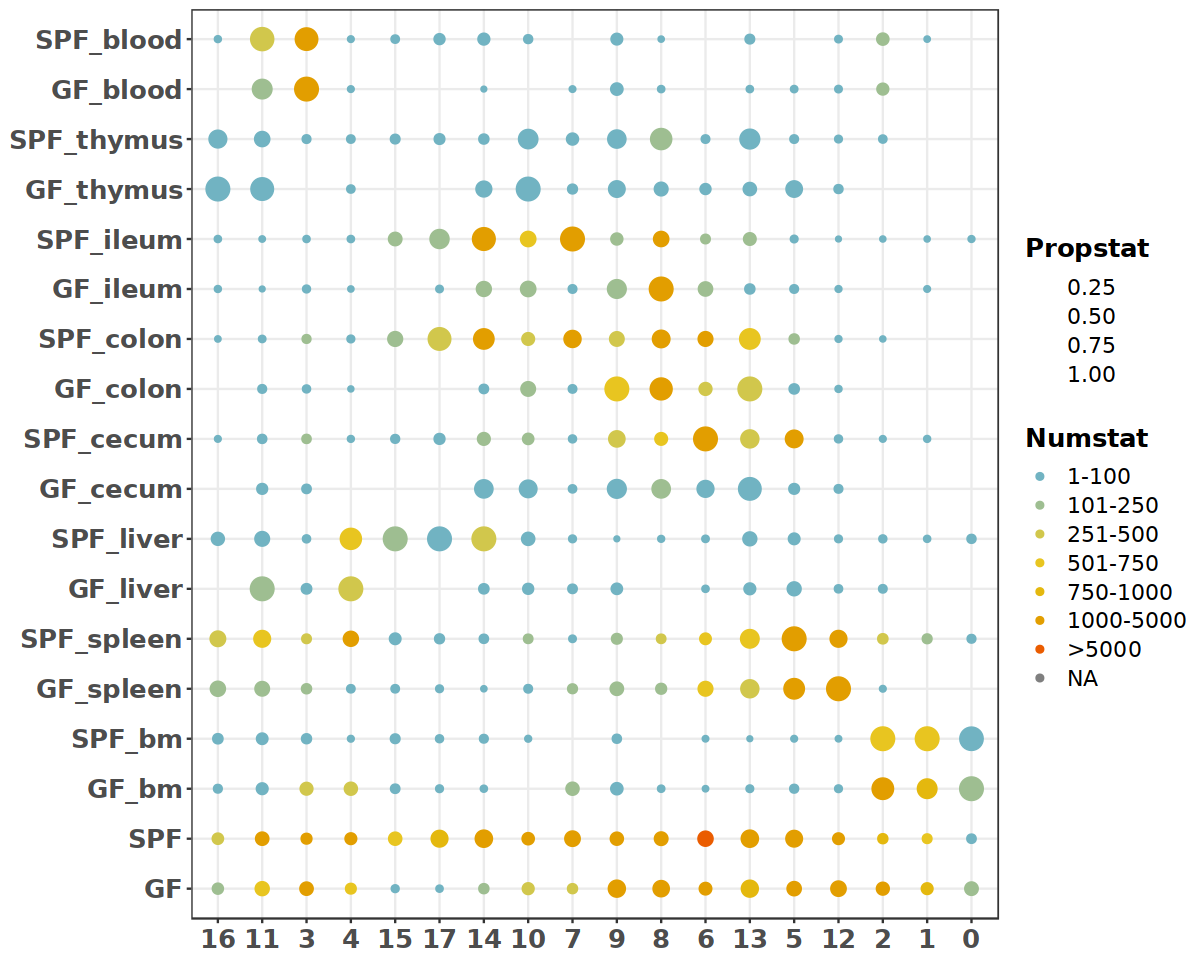

In [110]:
options(repr.plot.width = 10,repr.plot.height= 8)
p <- dotplot_custom(df_num = dat, rowlist = rowlist,collist =  collist,col_names = col_names)  
p

Figure 2D

In [18]:
SplitViolinPlot <- function(data,color=c("#00AFBB", "#E7B800")){
    mytheme <- theme(
        axis.text.y = element_text(size = 20,face = "bold",margin = margin(0,5,0,0)),
        axis.text.x = element_text(size = 20,face = "bold",margin = margin(5,0,0,0),angle = 45,
                                   hjust =1, vjust = 1),
        axis.title.x = element_text(size = 25,face = "bold",margin = margin(10,0,0,0)),
        axis.title.y = element_text(size = 25,face = "bold",margin = margin(0,10,0,0)),
        axis.line = element_line(linetype = 1,color= "black",size = 1),
        axis.ticks = element_line(linetype = 1,color= "black",size = 1,lineend = 100),
        legend.text = element_text(size = 16,face = "bold"),
        legend.title = element_text(size = 25,face = "bold"))+ 
               theme(legend.key.size = unit(1,"cm"), 
                  legend.spacing.x = unit(0.2,'cm'),
                  legend.spacing.y = unit(0.2,'cm'),
                  legend.text = element_text(margin = margin(t = 0,r = 0,b = 0,l =  0)))+
               theme(plot.title = element_text(size = 25,hjust = 0.5,face = "bold"),
                     plot.margin = margin(0,10,0,10))
    p <- ggplot(data, aes(ident, expression, fill = split)) +
         geom_split_violin(scale = "width", adjust = 1, trim = FALSE)+
         scale_fill_manual(values=color) + 
         scale_y_continuous(expand = c(0, 0),
                            position="left") +
         facet_grid(rows = vars(feature), scales = "free") + 
         theme_cowplot(font_size = 12) +
         theme(legend.position = "top",legend.justification = "center",
               panel.spacing = unit(0, "lines"),
               panel.background = element_rect(fill = NA, color = "black"),
               strip.background = element_blank(),
               strip.text = element_text(face = "bold",size = 20),
               strip.text.y.right = element_text(angle = 0,margin = margin(0,0,10,0))
              ) +
         ggtitle(" ") + ylab("Expression Level") + xlab("celltypes") + labs(fill = "mice") + mytheme 
    return(p)
} 

In [7]:
spleen <- readRDS("/data/work/FinallyPlot/FinallyData/old_rds/spleen_final_annotation_paper.rds")

In [8]:
str(spleen@meta.data)

'data.frame':	31572 obs. of  13 variables:
 $ orig.ident  : chr  "GF_spleen1" "GF_spleen1" "GF_spleen1" "GF_spleen1" ...
 $ nCount_RNA  : num  3547 5297 1597 4237 3368 ...
 $ nFeature_RNA: int  1368 2062 786 1633 1377 1231 2303 1064 1161 3151 ...
 $ percent.mt  : num  2.34 2.4 2.13 2.12 2.73 ...
 $ percent.ribo: num  17.6 12.3 16.4 20.8 10.5 ...
 $ percent.hb  : num  0 0 0 0 0 ...
 $ percent.plat: num  0 0 0.188 0 0 ...
 $ mice        : chr  "GF" "GF" "GF" "GF" ...
 $ tissue      : chr  "spleen" "spleen" "spleen" "spleen" ...
 $ doublet_info: chr  "Singlet" "Singlet" "Singlet" "Singlet" ...
 $ platform    : chr  "C4" "C4" "C4" "C4" ...
 $ celltypes   : Factor w/ 19 levels "Macrophage","cDC",..: 17 18 18 15 17 15 18 15 18 18 ...
 $ clusters    : Factor w/ 19 levels "0","1","2","3",..: 2 1 1 7 2 7 1 7 1 1 ...


In [12]:
unique(Idents(spleen))

[1] 1  0  6  4  12 7  13 9  2  5  3  18 10 11 17 8  16 15 14
Levels: 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0

In [11]:
table(spleen@meta.data$celltypes,spleen@meta.data$mice)

                         
                            GF  SPF
  Macrophage                61   51
  cDC                       22  102
  Endothelial               66  149
  Neutrophil(Il1b high)      0  224
  HSPC                      32  240
  pDC                      173  154
  Erythrocyte                9  397
  Pre-B/Pre-B cycling       99  369
  Neutrophil(S100a8 high)   10  524
  Gamma delta T cell       162  417
  Myeloid                  102  612
  Plasma                   158  556
  Erythrocyte cycling       19 1375
  NK                       819  577
  CD8+ T                  1218  312
  CD4+ T                   823 1214
  B cell (Ighd high)      2939 7822
  B cell (Cr2 high)       2101 2490
  Sell+ CD4 T             3834 1340

In [13]:
genelist <- c("Cr2","Ighd")
sp_sub <- subset(spleen,idents = c(0,1))
da <- VlnPlot(object = sp_sub, features = genelist, split.by = 'mice',raster=FALSE,
       stack = TRUE)$data

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



In [ ]:
options(repr.plot.width = 10,repr.plot.height= 8)
mycolor <- c("#F0E442","purple")
p <- SplitViolinPlot(data = da,color = mycolor)
p

Figure 2F

Figure 2G 

In [ ]:
DoEechPiePlot <- function(Counts,Genelist){## Experssion ##
 # Counts <- Counts[,Genelist]
  #print(head(Counts))
  data <- as.data.frame(Matrix::colSums(x = Counts > 0)) # whole express gene Connts > 0 # 
  colnames(data) <- "ExpStat"
  data$whole <- dim(Counts)[1] #  all spot ##
  data$gene <- rownames(data)
  data <- data %>% mutate(UnExpStat = whole - ExpStat)
  data$whole <- NULL
  plotlist <- list()
  for(i in 1:length(Genelist)){
    print(i)
    marker <- Genelist[i]
    print(marker)
    data.marker <- data %>% filter(gene == marker)
    print(data.marker)
    plot.marker <- melt(data.marker,id.vars = "gene")
    print(plot.marker)
    plot.marker$variable <- factor(plot.marker$variable,levels = c("UnExpStat","ExpStat"))
    plotlist[[marker]] <-  ggplot(data = plot.marker, mapping = aes(x = gene, y = value, fill = variable)) + 
                                geom_bar(stat = 'identity',  position = 'stack')+ coord_polar(theta = 'y') +
                                scale_fill_manual(values=c("#808080","#bd0000")) + 
                                labs(x = '', y = '', title = marker) + theme_void() + theme(
                                      plot.title = element_text(size = 25,family = "Times",face = "bold",hjust = 0.5),
                                legend.position = "none") 
  }
  return(plotlist)
}
DoUnionPiePlot <- function(Counts,Genelist,celltype){ 
  Counts <- Counts[,Genelist] ### question ###
  data <- as.data.frame(Counts > 0)
  data$Spot <- rownames(data)
  print(head(data))
  union.gene <- c()
  for(j in Genelist){
    print(j)
    exp.gene <- data[data[,j],"Spot"] # stat express Gene # 
    print(head(exp.gene))
    union.gene <- union(union.gene,exp.gene) # union Gene # 
  }
  print(length(union.gene))
  data.score  <- data.frame(ExpStat = length(union.gene),
                            UnExpStat = dim(Counts)[1] - length(union.gene),
                            celltype = celltype)
  print(data.score)
  plot.score <- melt(data.score,id.vars = "celltype")
  plot.score $variable <- factor(plot.score$variable,levels = c("UnExpStat","ExpStat"))
  p <- ggplot(data = plot.score, mapping = aes(x = celltype, y = value, fill = variable)) + 
    geom_bar(stat = 'identity',  position = 'stack')+ coord_polar(theta = 'y') +
    scale_fill_manual(values=c("#808080","#bd0000")) + 
    labs(x = '', y = '', title = celltype) + theme_void() + theme(
      plot.title = element_text(size = 16,family = "Times",face = "bold",hjust = 0.5),
      legend.position = "none") 
  return(p)
}

CellTypeMarkerPiePlot <- function(Counts,Celltypes,Markerlist,mice,sample,output,method){
  if(length(Celltypes) != length(Markerlist)){
    stop("Please check your number of vector of celltypes or marker ! ")
  }
  for(i in 1:length(Celltypes)){
    print(i)
    ct <- Celltypes[i]
    print(ct)
    mk <- Markerlist[[i]]
    print(mk)
    if(method == "experssion"){
      # each celltype Pieplot #
      pl <- DoEechPiePlot(Counts = Counts,Genelist = mk)
      p <- wrap_plots(pl,ncol = 1)
    } else if (method == "score"){
      p <- DoUnionPiePlot(Counts = Counts,Genelist = mk, celltype = ct)
      mk <- 1
    } else {
      stop("Please check your method !")
    } 
    # save #
    outfile <- paste(output,"/",sample,"_",ct,"_",method,".pdf",sep = "")
    print(outfile)
    pdf(outfile,w = 2,h = 2*length(mk))
    print(p)
    dev.off()
    print("--- end --- ")
  }
}

In [ ]:
GF <- readRDS("/data/work/Pieplot/final_GF.rds")
GF_counts <- t(as.matrix(GF$Spatial@counts))
sample <- 'GF_Spleen'
Celltypes <- c("Mature_B-C3")
output <- "/data/work/Pieplot"
Markerlist <- list("Mature_B-C3" = c("Ighd"))
CellTypeMarkerPiePlot(Counts = GF_counts,Celltypes = Celltypes, Markerlist = Markerlist,sample = sample,output = output,
                      method ="experssion")
date() 

Figure 2H

In [ ]:
TidyData <- function(obj,idx,idents=NULL){
  if(!is.null(idents)){
    pritn("Idents is not NULL!")
    Idents(obj) <- idents  
  }
  sub <- subset(obj,idents = idx)
  sub@meta.data$celltypes <- as.vector(sub@meta.data$celltypes )
  stat <- table(sub@meta.data$tissue,sub@meta.data$celltypes)
  print(stat)
  print(str(as.matrix(stat)))
  data <- as.data.frame(proportions(as.matrix(stat),margin = 1) * 100)
  print(data)
  colnames(data) <- c("tissue","celltypes","percentage")
  return(data)
}
CellRadioBarplot <- function(data,mycolor,title = NULL){ 
  theme_self <- theme(
    axis.text.y = element_text(size = 25,face = "bold",margin  = margin(0,5,0,0)),
    axis.text.x = element_text(size = 25,face = "bold",margin  = margin(0,0,0,0),angle = 45,hjust = 1,vjust =0.9),
    axis.title.x= element_text(size = 30,face = "bold",margin  = margin(0,0,0,0)),
    axis.title.y= element_text(size = 30,face = "bold",margin  = margin(0,0,0,0)),
    axis.line = element_line(linetype = 1,color= "black",size = 1),
    legend.text = element_text(size = 22,face = "bold"),
    legend.title = element_text(size = 28,face = "bold"),
    panel.grid = element_blank(),
    plot.margin =  unit(c(1,1,1,1),"cm"), 
    axis.ticks  = element_line(color = "black",size = 1,lineend = 2),
    plot.title = element_text(hjust = 0.5,size = 30,face = "bold"))
  p <- ggplot(data,aes(x = tissue,y = percentage,fill = celltypes)) + 
    geom_bar(stat="identity",width = 0.7) + theme_bw() + labs(x = " " , y = "Percentage (%)") +  
    scale_fill_manual(values=mycolor) + theme_self + 
    guides(fill=guide_legend(title = paste(title,"  ",sep = ""),position = "top",nrow = 2))
  return(p)
}